#  K-Means法を実装しよう!

この資料では、K-Means法のアルゴリズムについて詳細に説明をしていきます。

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

K-Means法を実装するにあたり、まず1500個のダミーデータを用意します。<br>
__以下のコードを覚える必要はありません！__

Text(0,0.5,'Sales')

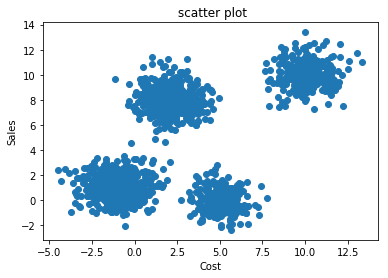

In [3]:
def generate_2dim_normal(mean, variance, covariance, sample_size):
    cov = [[variance,covariance],
           [covariance,variance]]
    return np.random.multivariate_normal(mean, cov, sample_size)

cluster1 = generate_2dim_normal(mean = [2, 8], variance=1, covariance=0, sample_size=500)
cluster2 = generate_2dim_normal(mean = [-1, 1], variance=1, covariance=0, sample_size=500)
cluster3 = generate_2dim_normal(mean = [10, 10], variance=1, covariance=0, sample_size=300)
cluster4 = generate_2dim_normal(mean = [5, 0], variance=0.8, covariance=-0.1, sample_size=200)
data = np.vstack((cluster1, cluster2, cluster3, cluster4))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(data[:,0], data[:,1])
ax.set_title(u" scatter plot")
ax.set_xlabel("Cost")
ax.set_ylabel("Sales")

In [4]:
cluster_num = 4

次に、ダミーデータからランダムに4つ選び、そのダミーデータと同じ地点を各クラスタのシードの初期地点として設定します。<br>
- `np.random.randint(L, size=S)`
    -  0 以上 L 未満の整数からランダムにS個数字を取得
- `len(行列)`
    - 行列の行数を取得

In [5]:
np.random.seed(100)  # 再現性を担保するために乱数の初期値を固定
seed_idx = np.random.randint(len(data), size=cluster_num)    # 0以上1500未満の数字からランダムに4つの数字(ID)を抽出している
seed_idx

array([792,  79, 350,  53])

シードの初期座標を取得しましょう。<br>
`data[[1, 2, 3]]`とすることで、dataの1行目と2行目と3行目のみを抽出することができます。

In [6]:
init_center = data[seed_idx]  # シードの初期座標を取得
init_center
#data.shape

array([[-2.73199024,  2.00999792],
       [ 2.08982786,  7.96443274],
       [ 2.91934435,  8.48741781],
       [ 1.60136834,  9.01864644]])

ここで、一度シードの初期位置をグラフで確認して見ましょう。オレンジの点がシードです。
<br>
__以下のコードを覚える必要はありません！__

Text(0,0.5,'x2')

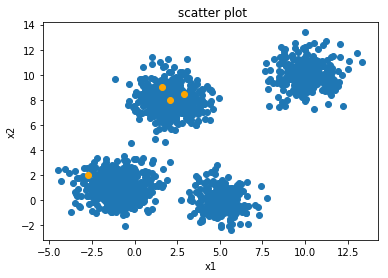

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(data[:,0], data[:,1])
ax.scatter(init_center[:,0], init_center[:,1], c='orange')
ax.set_title(u" scatter plot")
ax.set_xlabel("x1")
ax.set_ylabel("x2")

↑ランダムに4つのデータを選んで、それぞれをクラスターのシード（重心）の初期値とします。

---
## 2) 各データと各シードを比較し、最も近いシードと同じクラスターに分類します
---
ここでは、クラスタのラベルを取得する関数を作ります。

### クラスタのラベルを取得する関数
あるデータ点に着目した時に、各シード（クラスタの重心）までの距離を計算で求めます。その後に、最も距離が近いクラスタ番号を調べ、そのデータがどのクラスタに属するかを求めます。

【インプット】
- ダミーデータ (data)
- 現在のシードの位置 (center)

【アウトプット】
- 各データ点に対するクラスタのラベル情報 (cluster_labels)

In [8]:
def get_cluster_id_by_euclidian_distance(data, center):
    
    result = np.zeros([len(data), len(center)])
    
    #各データ点から各シード地点までの距離を計算
    for i in range(len(center)):
        square_total = ((data - center[i])**2).sum(axis=1)
        euclidian_distance = np.sqrt(square_total)
        result[:, i] = euclidian_distance
    
    #最も近いクラスタのラベルを取得
    cluster_labels = result.argmin(axis=1)
    return cluster_labels

上記の処理を1行ずつ見ていきましょう。

まず、1500個のダミーデータと、4つのシードの距離それぞれを格納するために、全ての要素が0の配列を作成します。
```
array([[ダミーデータ1とシード1の距離, ダミーデータ1とシード2の距離, ダミーデータ1とシード3の距離, ダミーデータ1とシード4の距離],
         [ダミーデータ2とシード1の距離, ダミーデータ2とシード2の距離, ダミーデータ2とシード3の距離, ダミーデータ2とシード4の距離],
         [ダミーデータ3とシード1の距離, ダミーデータ3とシード2の距離, ダミーデータ3とシード3の距離, ダミーデータ3とシード4の距離],
         [ダミーデータ4とシード1の距離, ダミーデータ4とシード2の距離, ダミーデータ4とシード3の距離, ダミーデータ4とシード4の距離],
         ...]])
```

In [9]:
result = np.zeros([len(data), len(init_center)])   # 今回はlen(data)は1500, len(init_center)は4ですので、np.zeros(1500, 4)となります
result

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [10]:
result.shape

(1500, 4)

続いて、各ダミーデータとシードとの距離を計算していきます。<br>
まずは各ダミーデータとシード1までの距離だけで考えて見ましょう。
- `sum(axis=1)`
    - 行ごとに、全ての要素を足し合わせます

In [11]:
square_total = ((data - init_center[0])**2).sum(axis=1)   #data - init_center[0] : 各ダミーデータからシード1までの距離の2乗を格納している
euclidian_distance = np.sqrt(square_total)   #距離に変換
euclidian_distance

array([7.2882708 , 7.41840729, 6.62731903, ..., 9.06210484, 9.7205941 ,
       9.75092597])

↑各ダミーデータからのシード1までの距離がそれぞれ格納されています。

この距離データをresultの1列目に格納します。

In [12]:
result[:,0] = euclidian_distance
result

array([[7.2882708 , 0.        , 0.        , 0.        ],
       [7.41840729, 0.        , 0.        , 0.        ],
       [6.62731903, 0.        , 0.        , 0.        ],
       ...,
       [9.06210484, 0.        , 0.        , 0.        ],
       [9.7205941 , 0.        , 0.        , 0.        ],
       [9.75092597, 0.        , 0.        , 0.        ]])

シード1, シード2, シード3, シード4をforループでまとめて処理します。

In [13]:
result = np.zeros([len(data), len(init_center)])

print('【初期値】   全て0' +'\n')
print(result)
print('\n'*2)

for i in range(len(init_center)):   #range(len(init_center)) = [0, 1, 2, 3]
    square_total = ((data - init_center[i])**2).sum(axis=1)
    euclidian_distance = np.sqrt(square_total)
    result[:, i] = euclidian_distance
    
    
    print('【%d回目】   シード%dまでの距離を%d列目に格納' %(i+1, i+1, i+1) + '\n')
    print(result) #計算過程をprint
    print('\n'*2)

【初期値】   全て0

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]



【1回目】   シード1までの距離を1列目に格納

[[7.2882708  0.         0.         0.        ]
 [7.41840729 0.         0.         0.        ]
 [6.62731903 0.         0.         0.        ]
 ...
 [9.06210484 0.         0.         0.        ]
 [9.7205941  0.         0.         0.        ]
 [9.75092597 0.         0.         0.        ]]



【2回目】   シード2までの距離を2列目に格納

[[ 7.2882708   0.50758709  0.          0.        ]
 [ 7.41840729  0.94357928  0.          0.        ]
 [ 6.62731903  1.07518218  0.          0.        ]
 ...
 [ 9.06210484  9.18311993  0.          0.        ]
 [ 9.7205941   9.59007959  0.          0.        ]
 [ 9.75092597 10.6881781   0.          0.        ]]



【3回目】   シード3までの距離を3列目に格納

[[ 7.2882708   0.50758709  1.4624675   0.        ]
 [ 7.41840729  0.94357928  1.35640735  0.        ]
 [ 6.62731903  1.07518218  1.96914802  0.        ]
 ...
 [ 9.06210484  9.18311993  9.35140044  0.     

次に、各データ点から最も距離が近いシードを求めます。<br>
- `np.min(ベクトル)`
    - ベクトルの中で最小の値を出力
- `np.argmin(ベクトル)`
    - ベクトルの中で最小の値が格納されているインデックスを出力

In [14]:
print('result[0] : ', result[0], '\n')
print('np.min(result[0]) : ', np.min(result[0]), '\n')
print('np.argmin(result[0]) : ', np.argmin(result[0]))

result[0] :  [7.2882708  0.50758709 1.4624675  1.13984628] 

np.min(result[0]) :  0.5075870900739425 

np.argmin(result[0]) :  1


各データ点と各シードまでの距離が格納されているresultに`np.argmin`を使うと、最も距離が近いシードの番号を出力してくれます。<br>

In [15]:
cluster_labels = np.argmin(result, axis=1)  #axis=1を指定することで、各データ点に対して最小のインデックスをベクトルとして出力してくれる
cluster_labels

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

---
## 3) k個のクラスターそれぞれで重心を求め、それを新たなシードとして更新します
 ---
 クラスタのシード（重心）を更新する関数を作成します。

### クラスタのシード（重心）を更新する関数
クラスタに属するデータ群から重心を計算し、シード位置を更新します。

【インプット】
- 現在の各クラスタのシードの座標 (prev_center)
- 各データ点のクラスタのラベル (cluster_labels)
- クラスタの数 (cluster_num)

【アウトプット】
- 更新後の各クラスタのシードの座標 (new_center)

In [16]:
def update_center(prev_center, cluster_labels, cluster_num):
    new_center = np.zeros(prev_center.shape)
    for i in range(cluster_num):
        new_center[i, :] = data[cluster_labels==i].mean(axis=0)
    return new_center

上記の処理を1行ずつ見ていきましょう。

まず、更新後の各シードの座標を格納するために、全ての要素が0の配列を作成します。<br>
```
array([[クラスタ1の更新後のシードのx座標, クラスタ1の更新後のシードのy座標],
         [クラスタ2の更新後のシードのx座標, クラスタ2の更新後のシードのy座標],
         [クラスタ3の更新後のシードのx座標, クラスタ3の更新後のシードのy座標],
         [クラスタ4の更新後のシードのx座標, クラスタ4の更新後のシードのy座標]]])
```

In [17]:
new_center = np.zeros(init_center.shape)
new_center

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [18]:
new_center.shape

(4, 2)

続いて、各クラスタに属するデータ群の重心を求めます。<br>
まず、クラスタ1の重心を計算してみましょう。

In [19]:
data[cluster_labels == 0]   #クラスタのラベルが0であるデータのx座標、y座標を抽出します。
#cluster_labels == 0


array([[-0.64725875,  0.9226478 ],
       [-1.83058644,  0.07967271],
       [-1.47672345, -0.19719504],
       ...,
       [ 5.90711185, -1.07303744],
       [ 6.02160878, -0.33440998],
       [ 6.19982975, -1.90192604]])

重心を計算するためには、`.mean(axis=0)`を使います。<br>`axis=0`に設定することで、x座標、y座標ごとに平均を求めることができます。

In [20]:
new_center[0,:] = data[cluster_labels == 0].mean(axis=0)
new_center

array([[0.34272618, 0.70182465],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])

↑1列目にクラスタ1の更新後の重心（x座標、y座標）を格納しています。

他のクラスタに関しても同様に重心を計算します。（forループ）

In [21]:
new_center = np.zeros(init_center.shape)
print('【初期値】   全て0' + '\n')
print(new_center)
print('\n'*2)

for i in range(cluster_num):  
    new_center[i, :] = data[cluster_labels==i].mean(axis=0)
    
    print('【%d回目】   クラスタ%dの重心を更新し%d行目に格納' %(i+1, i+1, i+1) + '\n')
    print(new_center)
    print('\n'*2)

【初期値】   全て0

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]



【1回目】   クラスタ1の重心を更新し1行目に格納

[[0.34272618 0.70182465]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]



【2回目】   クラスタ2の重心を更新し2行目に格納

[[0.34272618 0.70182465]
 [2.53463195 6.20652624]
 [0.         0.        ]
 [0.         0.        ]]



【3回目】   クラスタ3の重心を更新し3行目に格納

[[0.34272618 0.70182465]
 [2.53463195 6.20652624]
 [8.14855011 9.47776987]
 [0.         0.        ]]



【4回目】   クラスタ4の重心を更新し4行目に格納

[[0.34272618 0.70182465]
 [2.53463195 6.20652624]
 [8.14855011 9.47776987]
 [1.33622565 9.05411281]]





---
## 【演習】yourKmeans関数を完成させましょう

 ---
### 4) 重心の位置が変化しなくなるまで 2) ~ 3) を繰り返す
2)と3)でそれぞれ作成した関数を組み合わせて、<br>
データ群をクラスターに分類（クラスターラベルを取得）　→　クラスターの重心を更新<br>
という処理を重心の位置が変化しなくなるまで、繰り返し行います。

### K-Meansを実装する関数
K-Meansによるクラスタリングを行います。

【インプット】
- データ (data)
- クラスターの数 (cluster_num)
- 最大反復回数 (mas_iter)

【アウトプット】
- 各データごとのクラスターラベル （current_cluster_label)

In [30]:
def yourKmeans(data, cluster_num, max_iter):
    np.random.seed(10)
    seed_idx = np.random.randint(len(data),size=cluster_num)
    prev_center = data[seed_idx]

    for i in range(max_iter):
        cluster_labels == get_cluster_id_by_euclidian_distance(data, prev_center)

        new_center == update_center(prev_center, cluster_labels, cluster_num)
        prev_center=new_center
    
    return cluster_labels

これで、K-Means法の実装が完了となります！<br>
実際に、動かしてみましょう↓

In [32]:
cluster_num = 3
cluster_labels = yourKmeans(data=data, cluster_num=cluster_num, max_iter=100) 

C:\Users\hot_r\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


この出力結果を、下記の可視化用の関数に入力して確認しましょう<br>
__以下のコードを覚える必要はありません！__

In [33]:
def cluter_visualize(data, cluster_labels):

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
    cluster_ids = list(set(cluster_labels))
    for k in range(len(cluster_ids)):
        cluster_id = cluster_ids[k]
        label_ = "clutser = %d"%cluster_id
        data_by_cluster = data[cluster_labels == cluster_id]
        ax.scatter(data_by_cluster[:,0], data_by_cluster[:,1], c=colorlist[k], label = label_)

    ax.set_title(u"Clustering")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend(loc='lower right')

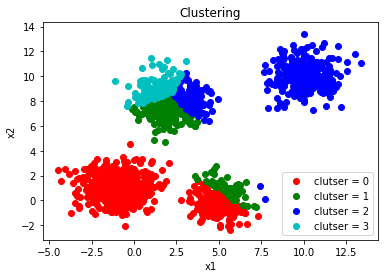

In [34]:
cluter_visualize(data=data, cluster_labels=cluster_labels)